# The Diamond OLG Model

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/diamondolg#launch)

### Convergence of OLG Economy to Steady State

In [1]:
# Some initial setup

from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')
from copy  import deepcopy

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from HARK.ConsumptionSaving.ConsIndShockModel import *

In [2]:
# Define a function that plots something given some inputs
def plot1(Epsilon, DiscFac, PopGrowth, YearsPerGeneration, kMax, Initialk):
    '''Inputs:
        Epsilon: Elasticity of output with respect to capital/labour ratio
        DiscFac: One period discount factor
        YearPerGeneration: No. of years per generation
        PopGrowth: Gross growth rate of population in one period'''
    
    # Define some parameters
    Beta = DiscFac**YearsPerGeneration
    xi = PopGrowth**YearsPerGeneration
    Q = (1-Epsilon)*(Beta/(1+Beta))/xi
    kBar = Q**(1/(1-Epsilon))
    
    # Create an agent that will solve the consumption problem
    PFagent = PerfForesightConsumerType(init_perfect_foresight)
    PFagent.cycles = 1 # let the agent live the cycle of periods just once
    PFagent.T_cycle = 2 # Number of periods in the cycle
    PFagent.PermGroFac = [0.] # Income only in the first period
    PFagent.LivPrb = [1.]
    
    PFagent.DiscFac = Beta
    
    # Hark seems to have trouble with log-utility
    # so pass rho = 1 + something small.
    PFagent.CRRA = 1.001
    
    PFagent.solve()
    
    # Plot the OLG capital accumulation curve and 45 deg line
    plt.figure(figsize=(9,6))
    kt_range = np.linspace(0, kMax, 1000)
    
    # Analitical solution plot
    ktp1 = Q*kt_range**Epsilon
    plt.plot(kt_range, ktp1, 'b-', label='Capital accumulation curve')
    plt.plot(kt_range, kt_range, 'k-', label='45 Degree line')
    
    # Plot the path
    kt_ar = Initialk
    ktp1_ar = 0.
    for i in range(3):
        
        # Compute Next Period's capital using HARK
        wage = (1-Epsilon)*kt_ar**Epsilon
        c = PFagent.solution[0].cFunc(wage)
        a = wage - c
        k1 = a/xi
        
        plt.arrow(kt_ar, ktp1_ar, 0., k1-ktp1_ar,
                  length_includes_head=True,
                  lw=0.01,
                  width=0.0005,
                  color='black',
                  edgecolor=None)
        plt.arrow(kt_ar, k1, k1-kt_ar , 0.,
                  length_includes_head=True,
                  lw=0.01,
                  width=0.0005,
                  color='black',
                  edgecolor=None)
        
        # Update arrow
        kt_ar = k1
        ktp1_ar = kt_ar
    
    # Plot kbar and initial k
    plt.plot(kBar, kBar, 'ro', label='kBar')
    plt.plot(Initialk, 0.0005, 'co', label = 'Initialk')
    
    plt.legend()
    plt.xlim(0 ,kMax)
    plt.ylim(0, kMax)
    plt.xlabel('$k_t$')
    plt.ylabel('$k_{t+1}$')
    plt.show()

    return None

In [3]:
# Define some widgets to control the plot

# Define a slider for Epsilon
Epsilon_widget1 = widgets.FloatSlider(
    min=0.1,
    max=.6,
    step=0.001,
    value=0.33,
    continuous_update=True,
    readout_format='.3f',
    description='$\epsilon$')

# Define a slider for the discount factor
DiscFac_widget1 = widgets.FloatSlider(
    min=.9,
    max=1.,
    step=0.0001,
    value=0.96,
    continuous_update=True,
    readout_format='.3f',
    description='$Disc. Fac$')

# Define a slider for pop. growth
PopGrowth_widget1 = widgets.FloatSlider(
    min=0.98,
    max=1.05,
    step=0.001,
    value=1.01,
    continuous_update=True,
    readout_format='.3f',
    description='$Pop. growth$')

# Define a slider for years per generation
YearsPerGeneration_widget1 = widgets.FloatSlider(
    min=20.,
    max=50,
    step=1,
    value=30,
    continuous_update=True,
    readout_format='.0f',
    description='$YrsPerGen$')

# Define a slider for initial k
Initialk_widget1 = widgets.FloatSlider(
    min=0.0000001,
    max=0.07,
    step=0.0001,
    value=.01,
    continuous_update=True,
    readout_format='.3f',
    description='$Initial k$')

# Define a textbox for k max
kMax_widget1 = widgets.FloatText(
    value=0.07,
    step=0.01,
    description='$kMax$',
    disabled=False)

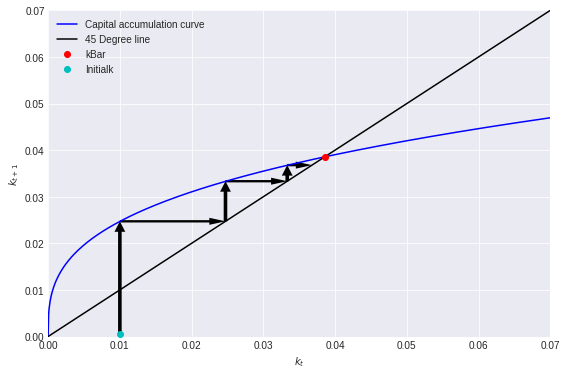

In [4]:
# Make the widget
interact(plot1,
         Epsilon = Epsilon_widget1,
         DiscFac = DiscFac_widget1,
         PopGrowth = PopGrowth_widget1,
         YearsPerGeneration = YearsPerGeneration_widget1,
         Initialk = Initialk_widget1,
         kMax = kMax_widget1,
        );

### Gross and Net Per Capita Output as a Function of k

In [5]:
# Define a function that plots something given some inputs
def plot2(Epsilon, PopGrowth, YearsPerGeneration, kMax):
    '''Inputs:
        Epsilon: Elasticity of output with respect to capital/labour ratio
        DiscFac: One period discount factor
        YearPerGeneration: No. of years per generation
        PopGrowth: Gross growth rate of population in one period'''
    
    # Define some parameters
    xi = PopGrowth**YearsPerGeneration
    Xi = xi - 1
    kBarForcZero = Xi**(1/(Epsilon-1))
    
    # Plot the production function and depreciation/dilution curves
    kt_range = np.linspace(0, kBarForcZero, 100)
    plt.figure(figsize=(18, 6))
    plt.subplot(1,2,1)
    plt.plot(kt_range, kt_range**Epsilon, 'b-', label = '$f(k)$')
    plt.plot(kt_range, Xi*kt_range, 'k-', label = '$Xi * k$')
    plt.legend()
    plt.xlim(0, kMax)
    plt.ylim(0, kMax*Xi)
    plt.xlabel('$k_t$')
    
    plt.subplot(1,2,2)
    plt.plot(kt_range, kt_range**Epsilon - Xi*kt_range, 'k-', label ='$f(k) - Xi * k$')
    plt.legend()
    plt.xlim(0, kMax)
    plt.ylim(0, kMax*Xi)
    plt.xlabel('$k_t$')
    
    plt.show()

    return None

In [6]:
# Define some widgets to control the plot

# Define a slider for Epsilon
Epsilon_widget2 = widgets.FloatSlider(
    min=0.1,
    max=.6,
    step=0.001,
    value=0.33,
    continuous_update=True,
    readout_format='.3f',
    description='$\epsilon$')

# Define a slider for pop. growth
PopGrowth_widget2 = widgets.FloatSlider(
    min=1.0001,
    max=1.05,
    step=0.001,
    value=1.01,
    continuous_update=True,
    readout_format='.3f',
    description='$Pop. growth$')

# Define a slider for years per generation
YearsPerGeneration_widget2 = widgets.FloatSlider(
    min=20.,
    max=50,
    step=1,
    value=30,
    continuous_update=True,
    readout_format='.0f',
    description='$YrsPerGen$')

# Define a textbox for k max
kMax_widget2 = widgets.FloatText(
    value=6,
    step=0.1,
    description='$kMax$',
    disabled=False)

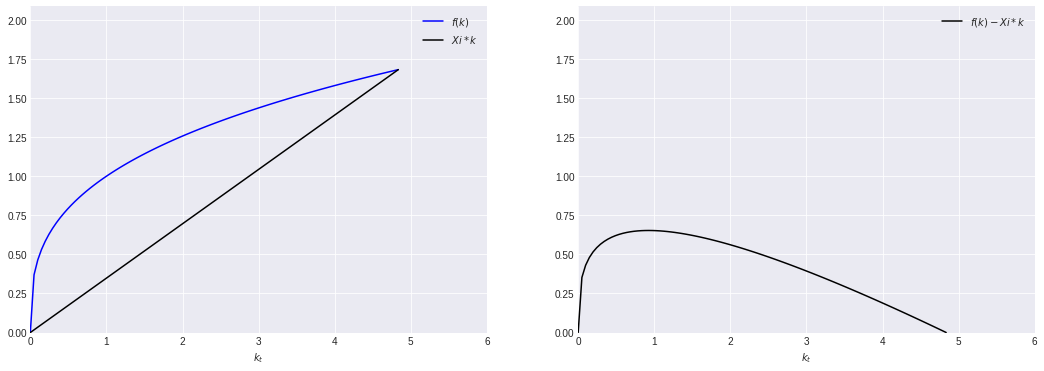

In [7]:
# Make the widget
interact(plot2,
         Epsilon = Epsilon_widget2,
         PopGrowth = PopGrowth_widget2,
         YearsPerGeneration = YearsPerGeneration_widget2,
         Initialk = Initialk_widget1,
         kMax = kMax_widget2,
        );